In [1]:
import os
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets, models
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline


DATA_PATH = "./data/gtsrb-german-traffic-sign/"

TRAIN_FILE = "./data/gtsrb-german-traffic-sign/Train.csv"
TEST_FILE = "./data/gtsrb-german-traffic-sign/Test.csv"

TRAIN_DATA_PATH = "./data/gtsrb-german-traffic-sign/Train/"
TEST_DATA_PATH = "./data/gtsrb-german-traffic-sign/Test/"

MODEL_CHECKPOINT_PATH = './model_checkpoints/'
TENSORBOARD_PATH = './runs/'

In [2]:
resize_image = 84
final_image_size = 32*2
rotate_deg = 15


transform_train = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.RandomRotation(rotate_deg),                      # Randomly rotate the image by up to 15 degrees
    # transforms.RandomHorizontalFlip(),                        # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2),                     # Randomly adjust brightness, contrast and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=2),       # Randomly ajust sharpness
    transforms.RandomPerspective(distortion_scale=.1, p=0.8),   # Rendomly changes the persective of the image
    transforms.RandomCrop((final_image_size, final_image_size)),# Randomly crop the image to 64x64
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2), 
    transforms.CenterCrop((final_image_size, final_image_size)),# Crop the center 64x64 portion of the image
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2), 
    transforms.CenterCrop((final_image_size, final_image_size)),# Crop the center 64x64 portion of the image
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])

In [3]:
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_train)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)

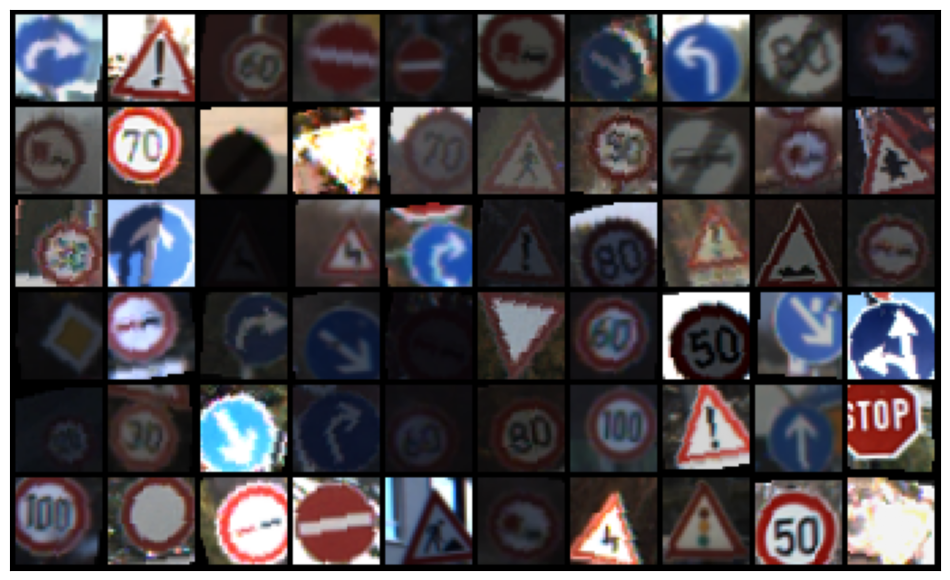

In [4]:
def ShowImages(dl, rows=6, cols=10):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:rows*cols], nrow=cols).permute(1, 2, 0).clamp(0,1))
        break

ShowImages(train_dataloader)

In [5]:
class RestNet18(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT
        self.resnet18 = models.resnet18(weights=weights, progress=False)
        n_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(n_ftrs, 43)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet18(x)

model = RestNet18()

In [6]:
def train_model(model, loader, optimizer, criterion, epoch, device, writer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Write the training loss and accuracy to TensorBoard
        iteration = epoch * len(loader) + i
        writer.add_scalar('Train/Loss', loss.item(), iteration)
        writer.add_scalar('Train/Accuracy', (predicted == labels).sum().item() / labels.size(0), iteration)

    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

In [7]:
def validation_model(model, loader, epoch, device, writer):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Write the validation loss and accuracy to TensorBoard
            iteration = epoch * len(loader) + i
            writer.add_scalar('Val/Loss', loss.item(), iteration)
            writer.add_scalar('Val/Accuracy', (predicted == labels).sum().item() / labels.size(0), iteration)

    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

In [8]:
# Unique identifier for the run
run = str(datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))                 

# Save path for tensorboard
writer_path = os.path.join(TENSORBOARD_PATH, f'{run}-tensorboard')
print('TensorBoard:', writer_path)

# Filename to save the model to
model_chckpoint_file = os.path.join(MODEL_CHECKPOINT_PATH, f'{run}-model.pt')

# Init the tensorboard writer
writer = SummaryWriter(writer_path)

n_epochs = 10

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Define the criterion used while training
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Common range for weight decay 1e-4 and 1e-2
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Define the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

model.to(device)    # Load the model to the device
for epoch in range(n_epochs):

    train_loss, train_acc = train_model(model, train_dataloader, optimizer,
                                        criterion, epoch, device, writer)
    val_loss, val_acc = validation_model(model, val_dataloader, epoch, device, writer)
    # scheduler.step()  # Reduce learning rate every epoch

    # Plot the epoch results
    print(f'Epoch [{epoch+1}/{n_epochs}] | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f}')

writer.flush()

TensorBoard: ./runs/2023-03-01_17:36:10-tensorboard
Using device:  cpu
Epoch [1/10] | Train Loss: 1.2061 | Val Loss: 0.3564 | Train Acc: 0.6463 | Val Acc: 0.8828
Epoch [2/10] | Train Loss: 0.2937 | Val Loss: 0.1397 | Train Acc: 0.9089 | Val Acc: 0.9559
Epoch [3/10] | Train Loss: 0.1622 | Val Loss: 0.0966 | Train Acc: 0.9502 | Val Acc: 0.9691
Epoch [4/10] | Train Loss: 0.1212 | Val Loss: 0.0701 | Train Acc: 0.9622 | Val Acc: 0.9800
Epoch [5/10] | Train Loss: 0.0950 | Val Loss: 0.0536 | Train Acc: 0.9702 | Val Acc: 0.9841
Epoch [6/10] | Train Loss: 0.0786 | Val Loss: 0.0726 | Train Acc: 0.9760 | Val Acc: 0.9755
Epoch [7/10] | Train Loss: 0.0785 | Val Loss: 0.0507 | Train Acc: 0.9764 | Val Acc: 0.9834
Epoch [8/10] | Train Loss: 0.0646 | Val Loss: 0.0441 | Train Acc: 0.9806 | Val Acc: 0.9860
Epoch [9/10] | Train Loss: 0.0625 | Val Loss: 0.0317 | Train Acc: 0.9810 | Val Acc: 0.9892
Epoch [10/10] | Train Loss: 0.0553 | Val Loss: 0.0351 | Train Acc: 0.9835 | Val Acc: 0.9892


In [9]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(model_chckpoint_file))

print('Model saved at:', model_chckpoint_file)

Model saved at: ./model_checkpoints/2023-03-01_17:36:10-model.pt


In [10]:
def evaluation_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    acc = correct / total

    print(f'Test Loss: {loss:.4f} | Test Acc: {acc:.4f}')

In [11]:

# Load test dataset
test_dataset = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2)

# Loading a saved model
checkpoint = torch.load(model_chckpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Evaluate the model
evaluation_model(model, test_dataloader, criterion, device)

Test Loss: 0.1589 | Test Acc: 0.9568


Bad pipe message: %s [b'\xb4V\xab\x88\xf4\xd5\x8e\x8e\x0f\xffT\x14+[*9^[ c\xe2Z\xca\xed\xe3\xa3\x90\\\x94Cb\xb7?i\xa0"\x0c\xcfJ\x05\xf2j!\x98\xb9Y\xad?e\xf8k\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00', b'\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06']
Bad pipe message: %s [b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 s&2\xa3\n\xa0\x9d\xf3\xa1\xd3Xz$\xae\xffs\x02\xfd\x90\x15:\xfc']
Bad pipe message: %s [b"\xc4\xda~h.\xf3E\xa0\x1f\xb9hNZ\x7f\xfe\xce\xd5\xf4\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R